In [4]:
import textattack
import transformers

2022-06-14 12:37:16.990610: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
model = transformers.AutoModelForSequenceClassification.from_pretrained("textattack/bert-base-uncased-SST-2")
tokenizer = transformers.AutoTokenizer.from_pretrained("textattack/bert-base-uncased-SST-2", use_fast=True)
model_wrapper = textattack.models.wrappers.HuggingFaceModelWrapper(model, tokenizer)

attack = textattack.attack_recipes.A2TYoo2021.build(model_wrapper)
dataset = textattack.datasets.HuggingFaceDataset("glue", "sst2", split="validation")

# Attack 20 samples with CSV logging and checkpoint saved every 5 interval
attack_args = textattack.AttackArgs(
    num_examples=20,
    csv_coloring_style="plain",
    log_to_csv="../results/log.csv",
    checkpoint_interval=20,
    disable_stdout=True
)

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
Reusing dataset glue (/home/coraline/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|███████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1158.43it/s]
textattack: Loading datasets dataset glue, subset sst2, split validation.


In [6]:
attacker = textattack.Attacker(attack, dataset, attack_args)
results = attacker.attack_dataset()
#for result in results:

textattack: Logging to CSV at path ../results/log.csv


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  gradient
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  20
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  False
        (compare_against_original):  True
      )
    (1): BERT(
        (metric):  cosine
        (threshold):  0.9
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.8
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
        (columns_to_ignore):  {'

  0%|                                                                                                | 0/20 [00:00<?, ?it/s]/home/coraline/anaconda3/envs/dpml/lib/python3.7/site-packages/torch/nn/modules/module.py:1033: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
[Succeeded / Failed / Skipped / Total] 2 / 17 / 1 / 20: 100%|███████████████████████████████| 20/20 [00:17<00:00,  1.13it/s]textattack: Saving checkpoint under "checkpoints/1655235483158.ta.chkpt" at 2022-06-14 12:38:03 after 20 attacks.
[Succeeded / Failed / Skipped / Total] 2 / 17 / 1 / 20: 100%|███████████████████████████████| 20/20 [00:17<00:00,  1.13it/s]





+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 2      |
| Number of failed attacks:     | 17     |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 95.0%  |
| Accuracy under attack:        | 85.0%  |
| Attack success rate:          | 10.53% |
| Average perturbed word %:     | 18.75% |
| Average num. words per input: | 15.8   |
| Avg num queries:              | 14.26  |
+-------------------------------+--------+


In [1]:
import numpy as np
import lime
import torch
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def predictor(texts):
    model.eval()
    inputs = tokenizer(texts, return_tensors="pt", padding=True).to(device)
    outputs = model(**inputs)
    probas = F.softmax(outputs.logits).detach().cpu().numpy()
    return probas

class_names = ['negative','positive']

explainer = LimeTextExplainer(class_names=class_names)

/home/coraline/anaconda3/envs/dpml/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_text_and_labels(results, idx, explainer):
    original_text = results[idx].original_result.attacked_text
    perturbed_text = results[idx].perturbed_result.attacked_text
    original_words = original_text.words
    perturbed_words = perturbed_text.words
    
    transformation_history = perturbed_text.le_attrs['transformation_history']
    order = {}
    for trans in transformation_history:
        ind = int(trans[trans.find('{')+1:trans.rfind('}')])
        order[ind]= len(order)
        
    modified_inds = []
    for i, token in enumerate(perturbed_text.tokens):
        if token.le_attrs['ops']:
            modified_inds.append(i)
    
    exp1 = explainer.explain_instance(original_text.printable_text(), predictor, num_features=5, num_samples=100).as_map()[1]
    exp2 = explainer.explain_instance(perturbed_text.printable_text(), predictor, num_features=5, num_samples=100).as_map()[1]
    
    return original_words, perturbed_words, order, (exp1, exp2)

In [7]:
idx = 3
original_words, perturbed_words, order, (exp1, exp2) = get_text_and_labels(results, idx, explainer)
lengths = list(map(lambda x, y: max(len(x), len(y)), original_words, perturbed_words))

/home/coraline/anaconda3/envs/dpml/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/home/coraline/anaconda3/envs/dpml/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


In [8]:
import matplotlib.pyplot as plt

def get_ax_size(ax):
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    width *= fig.dpi
    height *= fig.dpi
    return width, height

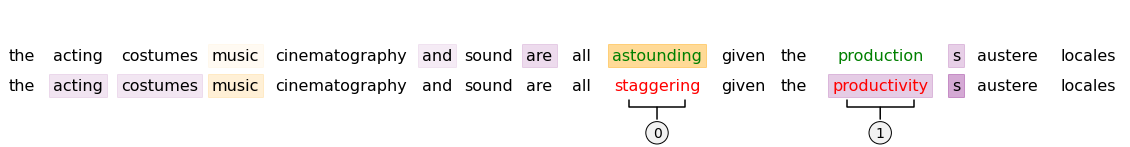

In [9]:
fig, ax = plt.subplots(2, len(original_words), figsize=(20,2), sharex=True, gridspec_kw={'width_ratios': lengths})

exp1_iter = iter(sorted(exp1))
exp2_iter = iter(sorted(exp2))

cur_exp1 = next(exp1_iter)
cur_exp2 = next(exp2_iter)


for i in range(len(original_words)):
    cur_ax = ax[1, i]
    above_ax = ax[0, i]
    above_ax.set_axis_off()
    cur_ax.set_axis_off()
    width, height = get_ax_size(cur_ax)
    width = width / height

    color1 = color2 = 'black'
    if i in order:
        color1 = 'green'
        color2 = 'red'
        cur_ax.annotate(str(order[i]), xy=(0.5, 0.2), xytext=(0.5, -0.5),
                       fontsize=14, ha='center', va='bottom', xycoords='axes fraction', 
                       bbox=dict(boxstyle='circle', fc='0.95'),
                       arrowprops=dict(arrowstyle=f'-[, widthB={width}, lengthB=.5', lw=1.5))
    pos_color = 'orange'
    neg_color = 'purple'
    kwargs1 = dict()

    if cur_exp1 and cur_exp1[0] == i:
        box_color = neg_color
        score = cur_exp1[1]
        if score > 0:
            box_color = pos_color
        try:
            cur_exp1 = next(exp1_iter)
        except StopIteration:
            cur_exp1 = None
            
        kwargs1 = dict(bbox=dict(facecolor=box_color, alpha= abs(score), edgecolor=box_color))
        
    kwargs2 = dict()
    if cur_exp2 and cur_exp2[0] == i:
        box_color = neg_color
        score = cur_exp2[1]
        if score > 0:
            box_color = pos_color
        try:
            cur_exp2 = next(exp2_iter)
        except StopIteration:
            cur_exp2 = None
        kwargs2 = dict(bbox=dict(facecolor=box_color, alpha= abs(score), edgecolor=box_color))
    
    above_ax.text(.5, 0, original_words[i], fontsize=16, color=color1, **kwargs1, horizontalalignment='center', verticalalignment='center',)
    cur_ax.text(.5, .6, perturbed_words[i], fontsize=16, color=color2, **kwargs2, horizontalalignment='center', verticalalignment='center',)
    